In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil

import omegaconf
import hydra
import numpy as np
import matplotlib.pyplot as plt
import swyft.lightning as sl
import torch
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# plt.switch_backend("agg")
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
cfg = omegaconf.OmegaConf.load("config_fermi.yaml")
from udens.plot import plt_imshow
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top
imkwargs_fermi = dict(extent=(-20., 20., -20., 20.), origin='lower') #left, right, bottom, top
from tqdm.notebook import tqdm as tqdm
import matplotlib.colors

In [3]:
def simulate(cfg):
    # Loading simulator (potentially bounded)
    simulator = hydra.utils.instantiate(cfg.simulation.model)

    # Generate or load training data & generate datamodule
    train_samples = sl.file_cache(
        lambda: simulator.sample(cfg.simulation.store.store_size),
        cfg.simulation.store.path,
    )[: cfg.simulation.store.train_size]
    datamodule = sl.SwyftDataModule(
        store=train_samples,
        simulator=simulator,  # Adds noise on the fly. `None` uses noise in store.
        batch_size=cfg.estimation.batch_size,
        num_workers=cfg.estimation.num_workers,
    )

    return datamodule, simulator
datamodule, simulator = simulate(cfg)

/home/eliasd/.pyenv/versions/3.9.7/envs/dens-3.9.7/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 10/10 [00:00<00:00, 1990.18it/s]


# Some sanity checks of the simulator

### N_E

In [5]:
simulator

Fermi_DM_SH_model(n_pix=64, GLON_center=0.0, GLAT_center=0.0, ROI_size=40.0, N_E=4, E_min=1.0, E_max=5.0, mDM=100, sigma_v=1.0, seed=20, N_SH_bound=[1, 5], nsub_expect=2.5, grid_low=array([  7., -20., -20.]), grid_high=array([10., 20., 20.]), bounds=None, device='cpu', z_sub_true=array([[  9.        ,  -2.1       ,  14.        ],
       [  8.69897   , -17.        ,   1.        ],
       [  8.47712125,   0.        ,   0.        ]]))

In [25]:
sample = simulator.sample(100)

100%|██████████| 100/100 [00:00<00:00, 2153.29it/s]


In [26]:
sample['mu'].shape

torch.Size([100, 64, 64])

### Number of Subhalos

In [27]:
sample['z_sub']

tensor([[[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  8.7335,  14.1939,   4.1314]],

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  9.0141,   8.5370,  -6.1072],
         [  8.0019,  -7.1245,  -1.1492]],

        ...,

        [[  0.0000,   0.0000,   0.0000],
         [  9.2104, -11.3751,  -6.1458],
         [  7.1156,  -9.4773,  11.3423],
         [  7.6167,   5.0881,   1.2585],
         [  7.0810, -17.4442, -18.5138]],

        [[  0.0000,   0.0000,   0.0000],
         [  7.8246,   0.4424, -18.3502],
         [  8.0008,  12.7755,  14.5762],
         [  9.3311,   1.7057,  14.3

Assuming only one energy bin

In [28]:
nonzeros = np.count_nonzero(sample['z_sub'][:,:,0].numpy(), axis = 1)

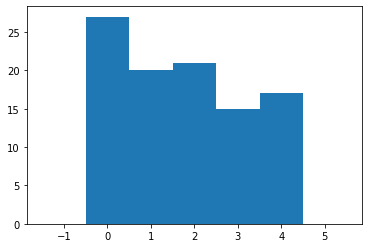

In [29]:
plt.hist(nonzeros, bins = np.arange(-1.5, 6.5));

In [30]:
np.count_nonzero(sample['z_sub'][:,:,0].numpy(), axis = 1).mean()

1.75

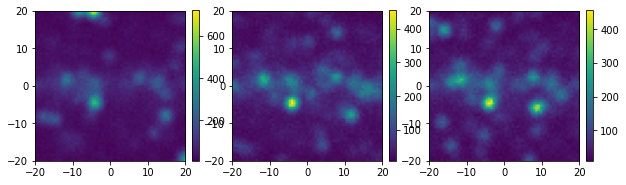

In [31]:
plt_imshow(sample['img'][:3], cbar = True, **imkwargs_fermi);

# Training and interpreting

In [20]:
sample['z_sub']

tensor([[[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  8.5864,  -2.0109,  19.6425]],

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  7.0169,  17.5132,   4.4407],
         [  9.1085,  16.1284,  12.7567]],

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  9.0603,   6.9265,   7.1755],
         [  7.0391,  18.0249,  10.6570]],

        [[  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  8.3208,  -4.4297,  14.9689],
        

In [10]:
def load(cfg, simulator):
    print('Loading trained network')
    tbl = pl_loggers.TensorBoardLogger(
        save_dir=cfg.tensorboard.save_dir,
        name=cfg.tensorboard.name,
        version=cfg.tensorboard.version,
        default_hp_metric=False,
    )
    logdir = (
        tbl.experiment.get_logdir()
    )  # Directory where all logging information and checkpoints etc are stored
    
    checkpoints = os.listdir( os.path.join(logdir, 'checkpoint') )
    if 'best.ckpt' in checkpoints:
        best_ckpt = 'best.ckpt'
    else:
        best_idx = np.argmax(list(map(int, [checkpoint[6:8] for checkpoint in checkpoints])))
        best_ckpt = checkpoints[best_idx]
    print(f'best checkpoint is {best_ckpt}')
    
    checkpoint = torch.load(
        os.path.join(logdir, f'checkpoint/{best_ckpt}'), map_location='cpu'
    )

    network = hydra.utils.instantiate(cfg.estimation.network, cfg)
    network.load_state_dict(checkpoint["state_dict"])

    train_samples = torch.load(cfg.simulation.store.path)
    
    trainer = sl.SwyftTrainer(accelerator=cfg.estimation.accelerator, gpus=1)
    trainer.setup(None)
    
    datamodule = sl.SwyftDataModule(store=train_samples, simulator=simulator)
    datamodule.setup(None)
    
    trainer.model = network
    
    return network, trainer, tbl, datamodule

def analyse(cfg, datamodule):
    # Setting up tensorboard logger, which defines also logdir (contains trained network)
    tbl = pl_loggers.TensorBoardLogger(
        save_dir=cfg.tensorboard.save_dir,
        name=cfg.tensorboard.name,
        version=cfg.tensorboard.version,
        default_hp_metric=False,
    )
    logdir = (
        tbl.experiment.get_logdir()
    )  # Directory where all logging information and checkpoints etc are stored

    # Load network and train (or re-load trained network)
    network = hydra.utils.instantiate(cfg.estimation.network, cfg)
    lr_monitor = LearningRateMonitor(logging_interval="step")
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=cfg.estimation.early_stopping.min_delta,
        patience=cfg.estimation.early_stopping.patience,
        verbose=False,
        mode="min",
    )
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=logdir + "/checkpoint/",
        filename="{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        mode="min",
    )
    trainer = sl.SwyftTrainer(
        accelerator=cfg.estimation.accelerator,
        gpus=1,
        max_epochs=cfg.estimation.max_epochs,
        logger=tbl,
        callbacks=[lr_monitor, early_stop_callback, checkpoint_callback],
    )
    best_checkpoint = logdir + "/checkpoint/best.ckpt"
    if not os.path.isfile(best_checkpoint):
        trainer.fit(network, datamodule)
        shutil.copy(checkpoint_callback.best_model_path, best_checkpoint)
        trainer.test(network, datamodule)
    else:
        trainer.fit(network, datamodule, ckpt_path=best_checkpoint)

    return network, trainer, tbl

network, trainer, tbl, datamodule = load(cfg, simulator)
# network, trainer, tbl = analyse(cfg, datamodule)

Loading trained network
best checkpoint is best.ckpt
Prior,    M_frac    in subhalo log10 mass range
1.53e-04, 2.50e-01:    [7.000 - 7.750]
1.53e-04, 2.50e-01:    [7.750 - 8.500]
1.53e-04, 2.50e-01:    [8.500 - 9.250]
1.53e-04, 2.50e-01:    [9.250 - 10.000]


/home/eliasd/.pyenv/versions/3.9.7/envs/dens-3.9.7/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/eliasd/.pyenv/versions/3.9.7/envs/dens-3.9.7/lib/python3.9/site-packages/pytorch_lightning/trainer/callback_hook.py:74: LightningDeprecationWarning: `TrainerCallbackHookMixin.setup` was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("`TrainerCallbackHookMixin.setup` was deprecated in v1.6 and will be removed in v1.8.")


In [6]:
nonzeros = np.count_nonzero(sample['z_sub'][:,:,0].numpy(), axis = 1)

In [11]:
def interpret(cfg, simulator, network, trainer, datamodule, tbl):
    hydra.utils.call(
        cfg.inference.interpreter, cfg, simulator, network, trainer, datamodule, tbl
    )
interpret(cfg, simulator, network, trainer, datamodule, tbl)

Prior,    M_frac    in subhalo log10 mass range
1.53e-04, 2.50e-01:    [7.000 - 7.750]
1.53e-04, 2.50e-01:    [7.750 - 8.500]
1.53e-04, 2.50e-01:    [8.500 - 9.250]
1.53e-04, 2.50e-01:    [9.250 - 10.000]


100%|██████████| 1/1 [00:00<00:00, 1360.02it/s]


logdir: ./lightning_fermi/poisson_noise_sub1-5_GLON0.0_GLAT0.0_ROI40.0x40.0deg_pix64_Ebins1_msc4_sim10000/version_0


In [12]:
# @hydra.main(config_path=".", config_name="config")
# def main(cfg):
#     print_dict(cfg)
#     datamodule, simulator = simulate(cfg)
    
#     if cfg.load:
#         network, trainer, tbl, datamodule = load(cfg, simulator)
#     else:
#         network, trainer, tbl = analyse(cfg, datamodule)
#     interpret(cfg, simulator, network, trainer, datamodule, tbl)


# if __name__ == "__main__":
#     main()